We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add PRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/PRA2D")

# Overview

In the following notebok we evaluate the Polar Rotation Angle ($ \mathrm{PRA} $) on a 2-D homogeneous, isotropic turbulence. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{PRA} $:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary meshgrid. 
    <br />
    * Compute left and right singular vectors $ \xi_{1,2}(\mathbf{x}_0), \eta_{1,2}(\mathbf{x}_0) $ of the gradient of the flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $.
    <br />
    * Compute $ \mathrm{PRA} $ as:
    
    \begin{equation}
    \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \cos^{-1}(\langle \eta_{2}(\mathbf{x}_0), \xi_{2}(\mathbf{x}_0) \rangle) = \cos^{-1}(\langle \eta_{1}(\mathbf{x}_0), \xi_{1}(\mathbf{x}_0) \rangle).
    \end{equation}
    
    As the eigenvector associated to the maximum singular value of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ is numerically more stable, we compute the PRA using $ \mathbf{\eta}_2, \mathbf{\xi}_2 $:
       
    \begin{equation}
    \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \cos^{-1}(\langle \eta_{2}(\mathbf{x}_0), \xi_{2}(\mathbf{x}_0) \rangle).
    \end{equation}
 <br />
6. References

# Import data

In [2]:
# import scipy
import scipy.io

# import numpy
import numpy as np

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 16

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time 
t0 = 0 # float

# Final time 
tN = 10 # float

# Time step-size 
dt = 0.1 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# resolution
Nx = 500
Ny = 500

# specify domain over which to compute LCS
x_domain = np.linspace(3, 5, Nx)
y_domain = np.linspace(1, 3, Ny)

# set x-limits
xmin = np.min(x_domain)
xmax = np.max(x_domain)

# set x-limits
ymin = np.min(y_domain)
ymax = np.max(y_domain)

# grid-spacing
dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

# $ \mathrm{PRA} $

Next, we compute the $ \mathrm{PRA} $ over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. We then compute the PRA from the left and right singular vectors of the gradient of the flow map. 

In [6]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute polar rotation angle (PRA)
from ipynb.fs.defs.PRA import _PRA

# Import package for parallel computing
from joblib import Parallel, delayed

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

def parallel_PRA(x0_batch, y0_batch):
    
    # Initial condition
    X0 = np.array([x0_batch, y0_batch])

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # array (Nt, 2, 2, Nx*Ny)

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (2, 2, Nx*Ny)

    # Compute PRA
    PRA = []
    for i in range(gradFmap_t0_tN.shape[2]):
        PRA.append(_PRA(gradFmap_t0_tN[:,:,i]))
    
    return PRA

In [7]:
# compute PRA
results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_PRA)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract PRA from results of parallel computing
PRA = results[0]

for res in results[1:]:
    PRA = np.append(PRA, res)
    
# Reshape array from vectorized form to structured meshgrid for plotting purposes
PRA_gridded = PRA.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)

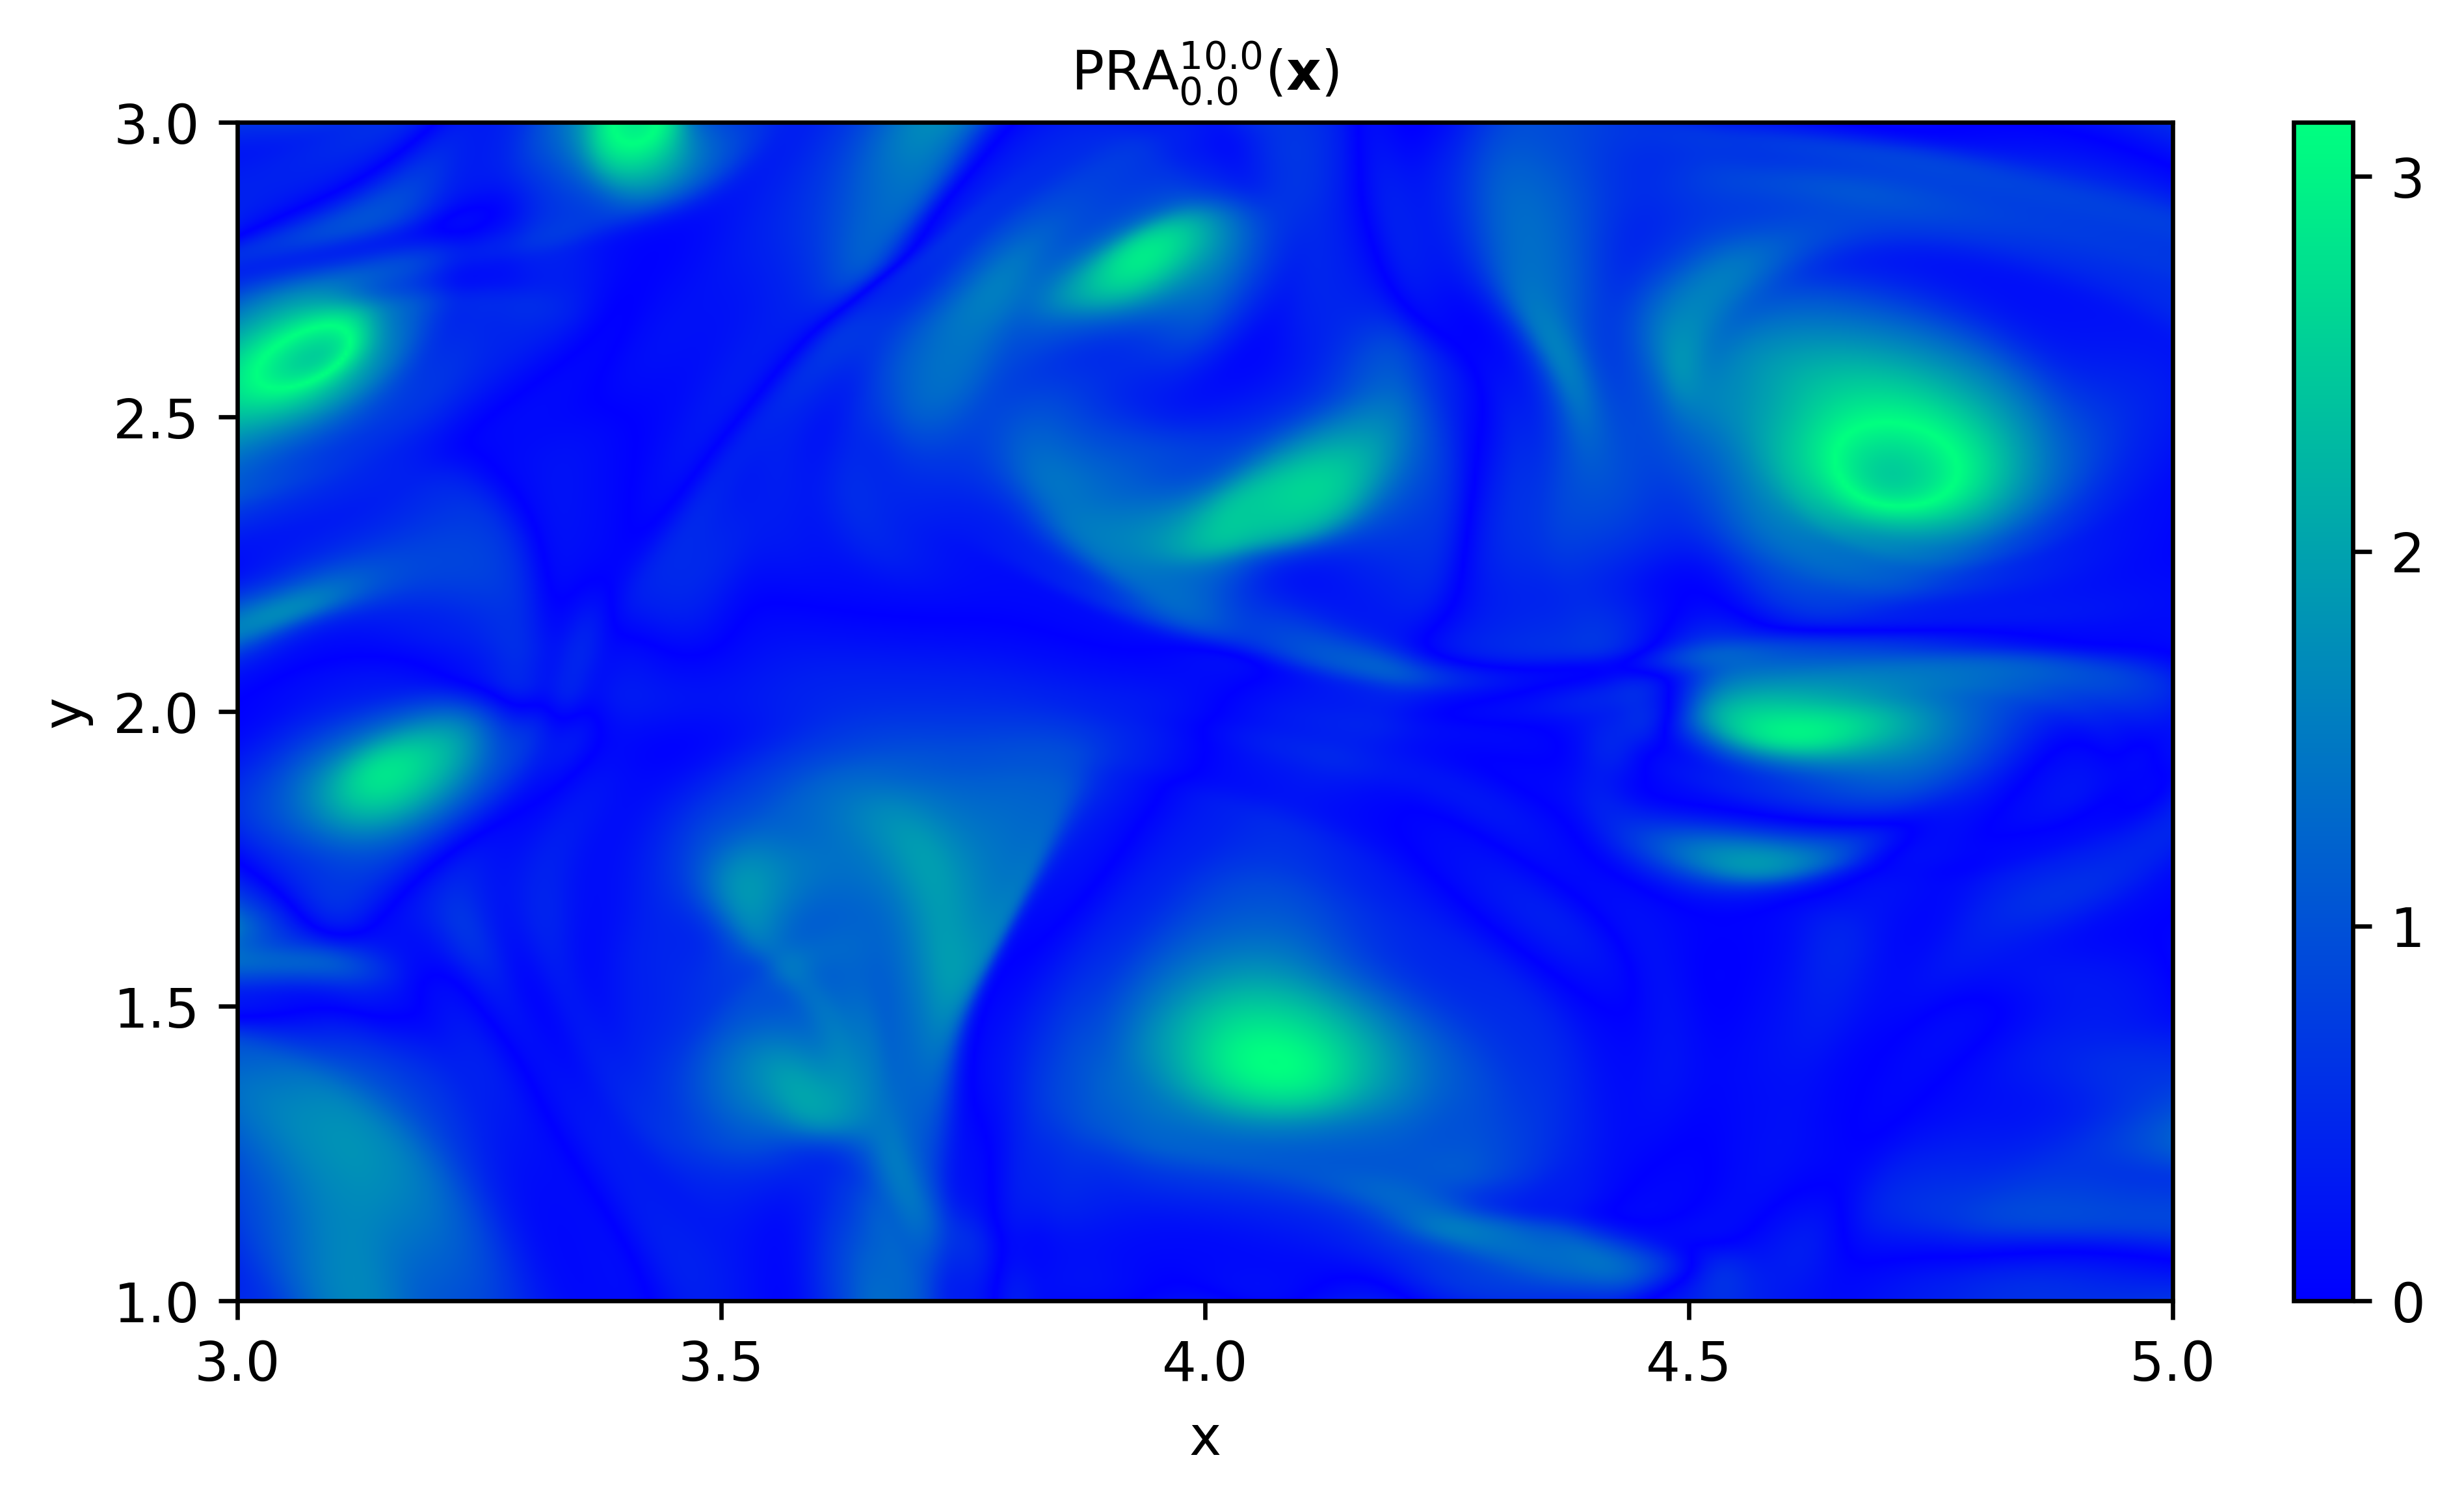

In [8]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of PRA over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(PRA_gridded), cmap = "winter", levels = 600)

# Axis Labels
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, .5))
ax.set_yticks(np.arange(ymin, ymax+0.1, .5))

# Colorbar
cbar = fig.colorbar(cax, ticks = [0, 1, 2, 3])

# Title
ax.set_title(r'$ \mathrm{PRA}$'+f'$_{{{np.around(time[0],2)}}}^{{{np.around(time[-1],2)}}}$'+r'$(\mathbf{x})$', fontsize = 10)

plt.show()

Elliptic LCS are identified as elliptic islands around local minima in the $ \mathrm{PRA} $-field. The elliptic LCSs are visible as nested concentric closed contours of the $ \mathrm{PRA} $ at time $ t_0 $. These elliptic islands clearly distinguish vortical regions from the remaining flow. Note that the $ \mathrm{PRA} $ highlights the same vortical flow structures as other commonly used rotation diagnostics such as the [EllipticLCS](../../EllipticLCS/Main/EllipticLCSTurbulence.ipynb) or the [LAVD](../../LAVD2D/Main/LAVDTurbulence.ipynb).

# References

[1] Farazmand, M., & Haller, G. (2016). Polar rotation angle identifies elliptic islands in unsteady dynamical systems. Physica D: Nonlinear Phenomena, 315, 1-12.

[2] Notebook 5.2.7 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller